Source: https://www.kaggle.com/gyejr95/league-of-legends-challenger-ranked-games2020

## Um pouco sobre o league of legends e sobre este notebook

League of Legends (LoL) é um jogo multiplayer, modo arena de batalha, desenvolvido pela empresa Riot Games, onde o objetivo final é destruir a base inimiga. O mapa contém diversos objetivos que podem vatagens aos que os fizerem, como:

- **Tropas:** Tropas são unidades associadas a um dos times controladas pelo computador. Elas surgem periodicamente do próprio nexus e avançam pelas rotas em direção ao nexus inimigo. As tropas inimigas garantem ouro ao jogador que a abateu.

- **Dragões, Rubrivira (Red/Vermelho), Azuporã (Blue/Azul) e Barão Nashor:** Ficam situados na Jungle e garantem buffs nos status e experiência de nível quando que o abatidos.

- **Trevoguari (Lobos),  Grompe (Sapão), Acuâmina (Galinha) e Krugues (Pedras):** Ficam situados na Jungle e garantem experiência de nível quando abatidos.

- **Aronguejo (Caranguejo):** Ficam situados nos rios e garantem experiência de nível e visão no mapa quando abatidos.

- **Torres:** Liberam um espaço na rota até o nexus inimigo quando destruida.

- **Inibitor:** Quando destruida libera minnions inimigos mais poderosos na rota a qual esse inibidor era responsável.

- **Nexus:** Garante a vitória ao time que o destroiu.

Além disso o jogo conta com mais de 160 personagens jogáveis, cada um com um kit de habilidades diferente e status base unicos, e as partidas contam com 10 jogadores simultâneos, sendo 5 do time azul e cinco do time vermelho, cada um com uma função pré definida e responsável por defender uma área do mapa.

**Representação do minimapa com as principais localizações:**
![alt text](https://s2.glbimg.com/7YyoN-q2hqslIYiSD5I_aWrmXlE=/0x0:1600x1337/984x0/smart/filters:strip_icc()/i.s3.glbimg.com/v1/AUTH_08fbf48bc0524877943fe86e43087e7a/internal_photos/bs/2018/j/U/wOtnlBRQOqIM2D4UZnqQ/mapa1-marca.jpg "Logo Title Text 1")


O jogo também tem um sistema de rankeamento baseado em divisões e de pontos (Chamados de pontos de liga ou PDL). Os pontos de liga são distribuídos aos jogadores de forma que eles ganham PDL caso vençam e perdem PDL caso percam a partida. Os três primeiros divisões são:

- Desafiante (Challenger)
- Grão Mestre (Grand Master)
- Mestre (Master)

Os meios de se sobrepor perante o inimigo e triunfar no campo de batalha são diversos e o jogo acaba por se tornar uma mistura entre habilidade individual e estratégia!

Neste notebook estaremos realizando uma análise focada nos quesitos estratégicos nos rankings mais altos do jogo para descobrir quais são os fatores mais impactantes em uma partida para garantir a vitória!

In [1]:
!ls -la

total 1172
drwxrwxr-x 4 talesaraujo talesaraujo    4096 ago  9 16:28 .
drwxrwxr-x 4 talesaraujo talesaraujo    4096 ago  9 14:17 ..
-rw-rw-r-- 1 talesaraujo talesaraujo      30 ago  9 14:34 .gitignore
drwxrwxr-x 2 talesaraujo talesaraujo    4096 ago  9 14:22 .ipynb_checkpoints
-rw-rw-r-- 1 talesaraujo talesaraujo 1178117 ago  9 16:28 lol_challenger_ranked.ipynb
drwxrwxr-x 2 talesaraujo talesaraujo    4096 ago  9 14:28 lol_data


In [2]:
# Download do dataset (Kaggle)
# !mkdir ~/.kaggle
# !echo "{\"username\":\"username\",\"key\":\"key\"}" > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
#!kaggle datasets download gyejr95/league-of-legends-challenger-ranked-games2020

In [4]:
# !unzip league-of-legends-challenger-ranked-games2020.zip -d lol_data
# !rm league-of-legends-challenger-ranked-games2020.zip

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

DATAPATH = 'lol_data'

O dataset escolhido por nós contêm informações de partidas das três principais divisões.

In [51]:
c_df = pd.read_csv(f'{DATAPATH}/Challenger_Ranked_Games.csv')
gm_df = pd.read_csv(f'{DATAPATH}/GrandMaster_Ranked_Games.csv')
m_df = pd.read_csv(f'{DATAPATH}/Master_Ranked_Games.csv')

Preferimos por unificar os três datasets em um só e criar uma nova coluna apenas com o Elo de cada partida

In [52]:
challenger_series = pd.Series(['challenger' for i in range(c_df.shape[0])])
grandmaster_series = pd.Series(['grandmaster' for i in range(gm_df.shape[0])])
master_series = pd.Series(['master' for i in range(m_df.shape[0])])

In [53]:
c_df['ranking'] = challenger_series
gm_df['ranking'] = grandmaster_series
m_df['ranking'] = master_series

In [54]:
frames = [c_df, gm_df, m_df]

df = pd.concat(frames)
df.reset_index(inplace=True, drop=True)

Foi necessário também criar uma nova coluna com a duração das partidas em minutos para que pudessemos realizar as analises que desejávamos

In [55]:
df.rename(columns={"gameDuraton": "gameDuration"}, inplace=True)

# Adding a column to keep track of game duration in minutes
df.insert(loc=2, column='gameDurationMins', value=round(df['gameDuration']/60))

rankings = df['ranking']
df.drop(labels=['ranking'], axis=1, inplace=True)
df.insert(1, 'ranking', rankings)

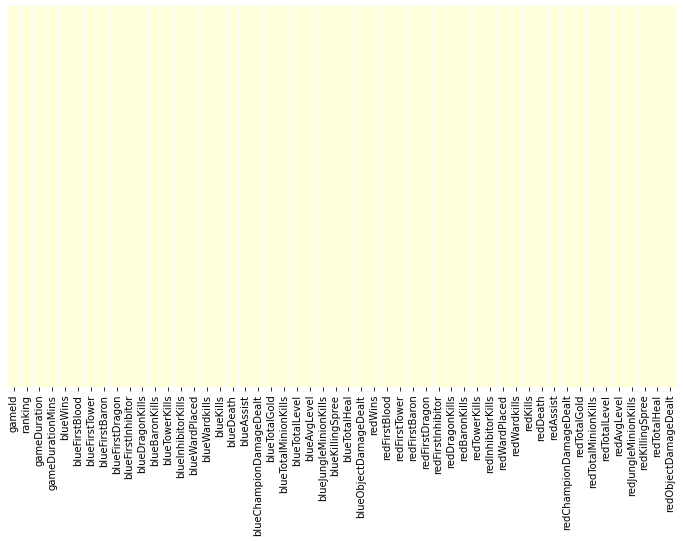

In [56]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')

## Barão antes dos 20?

Descobrimos dados errôneos nas colunas referentes ao objetivo "Barão", uma vez que tinham partidas de menos de 20 minutos de duração que já tinham barons abatidos e em uma partida comum ele só aparece no mapa e fica disponível para ser abatido depois dos 20 minutos de partida.

Logo tivemos que deletar as linhams que continham essas informações.

In [82]:
columns = ['blueFirstBaron', 'redFirstBaron', 'blueBaronKills', 'redBaronKills']

for column in columns:
    column_logical_values = np.logical_and(df['gameDurationMins'] < 20, df[column] == 1)
    column_indexes = [i for i, value in enumerate(column_logical_values) if value]
    df.drop(df.index[[column_indexes]], inplace=True)
    df.reset_index(drop=True, inplace=True)

In [83]:
blue_f_baron = np.logical_and(df['gameDurationMins'] < 20, df['blueFirstBaron'] == 1).sum()
red_f_baron = np.logical_and(df['gameDurationMins'] < 20, df['redFirstBaron'] == 1).sum()
blue_baron_kills = np.logical_and(df['gameDurationMins'] < 20, df['blueBaronKills'] == 1).sum()
red_baron_kills = np.logical_and(df['gameDurationMins'] < 20, df['redBaronKills'] == 1).sum()

print(blue_f_baron, red_f_baron, blue_baron_kills, red_baron_kills)

0 0 0 0


## Legenda sobre os nomes das colunas

- **GameId:** Número único atrelado a toda a partida de League of Legends
- **Ranking:** Divisão (ELO) da partida
- **gameDuration:** Duração da partida em segundos
- **gameDurationMins:** Duração da partida em minutos

In [12]:
df.head(5)

,gameId,ranking,gameDuration,gameDurationMins,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt,redWins,redFirstBlood,redFirstTower,redFirstBaron,redFirstDragon,redFirstInhibitor,redDragonKills,redBaronKills,redTowerKills,redInhibitorKills,redWardPlaced,redWardkills,redKills,redDeath,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4247263043,challenger,1323,22.0,0,1,0,0,0,0,0,0,0,0,38,13,15,31,22,56039,37001,440,56,11.2,105,4,31035,5675,1,0,1,0,1,1,3,0,9,1,50,17,31,15,68,73016,49832,533,64,12.8,138,8,38711,60463
1,4247155821,challenger,1317,22.0,1,0,0,0,1,0,2,0,4,0,57,18,19,8,31,60243,41072,531,63,12.6,111,3,26397,45303,0,1,1,0,0,0,0,0,2,0,46,18,8,19,8,44218,37136,571,59,11.8,134,3,24829,14105
2,4243963257,challenger,932,16.0,0,0,0,0,0,0,0,0,0,0,28,7,5,20,8,24014,22929,306,42,8.4,64,0,6567,5651,1,1,1,0,1,1,2,0,5,1,40,9,20,5,20,30797,35364,400,50,10.0,89,5,12589,45201
3,4241678498,challenger,2098,35.0,0,0,0,1,1,0,1,1,2,0,129,39,26,36,45,101607,63447,774,80,16.0,226,3,24718,31019,1,1,1,0,0,0,3,1,6,0,96,56,36,26,72,125866,70528,832,84,16.8,205,9,65312,88202
4,4241538868,challenger,2344,39.0,1,1,1,1,1,1,2,2,11,3,114,35,27,40,47,134826,74955,831,83,16.6,252,5,37161,95287,0,0,0,0,0,0,3,1,6,1,100,43,40,27,83,131536,74596,794,85,17.0,227,7,86431,64141


### Quantidade de partidas por elo no dataset

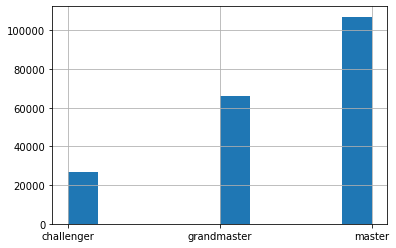

In [13]:
df['ranking'].hist()

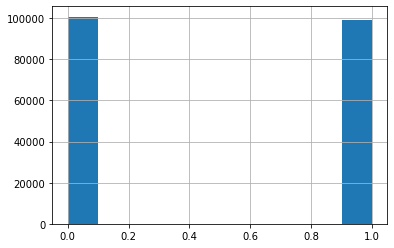

In [14]:
df['blueWins'].hist()

In [15]:
# plt.figure(figsize=(10, 5))
# sns.distplot(df['gameDurationMins'], hist=True, kde=False)
# plt.xlabel("Number of games")
# plt.ylabel("Game Duration (mins)")

In [16]:
df['ranking'].value_counts()

master         107125
grandmaster     65896
challenger      26904
Name: ranking, dtype: int64

### Duração de partidas agrupadas por ELO

Uma informação interessante que encontramos analisando esse gráfico foi que nos minutos 15, 20 e 30 houve um pico de términos nas partidas.

Isso pode se dar pelo fato de que os minutos 15 e 20 são os que liberam a possibilidade de se render e declarar automaticamente a vitória para o time inimigo, para tal, caso um time inicie a votação para se render entre o minuto 15 e o minuto 20 é necessário que todos do time votem a favor, a partir do minuto 20 é necessário apenas que 4 dos cinco jogadores do time que iniciou a votação concordem com a rendição.

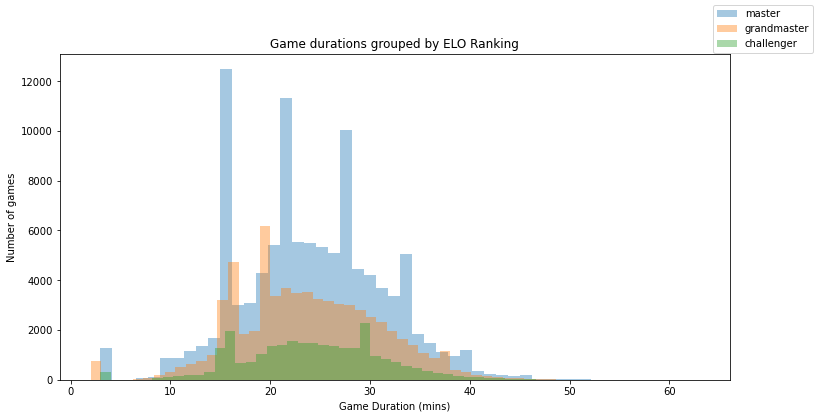

In [17]:
rankings = ['master', 'grandmaster', 'challenger']
game_durations_by_ranking = [df[df['ranking'] == rank]['gameDurationMins'] for rank in rankings]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set(ylabel='Number of games')
for i, game in enumerate(game_durations_by_ranking):
    sns.distplot(game, hist=True, kde=False, axlabel="Game Duration (mins)", label=rankings[i])
ax.set_title("Game durations grouped by ELO Ranking")
fig.legend()
plt.show()

In [18]:
data = df["blueWins"].value_counts()
data

0    100771
1     99154
Name: blueWins, dtype: int64

### Verificando a porcentagem de vitória por lado do mapa

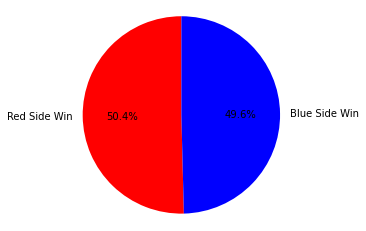

In [19]:
labels = ["Red Side Win", "Blue Side Win"]

fig, ax = plt.subplots()
ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, colors='rb')
ax.axis('equal')

plt.show()

In [20]:
columns = ['redWins', 'blueWins']

win_mapping = {0: "DEFEAT", 1: "WIN"}

for col in columns:
    df[col]= df[col].map(win_mapping)

### Verificando a quantidade de vitórias por lado do mapa

Aqui podemos mais uma vez ver a ligeira vantagem do time vermelho para a conquista da vitória em Summoners Rift.

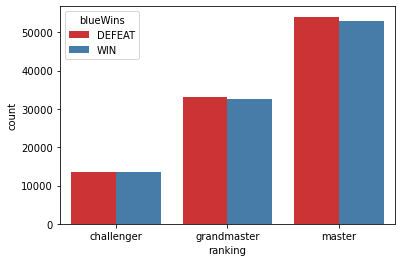

In [21]:
sns.countplot(x=df['ranking'], hue=df['blueWins'], palette="Set1")

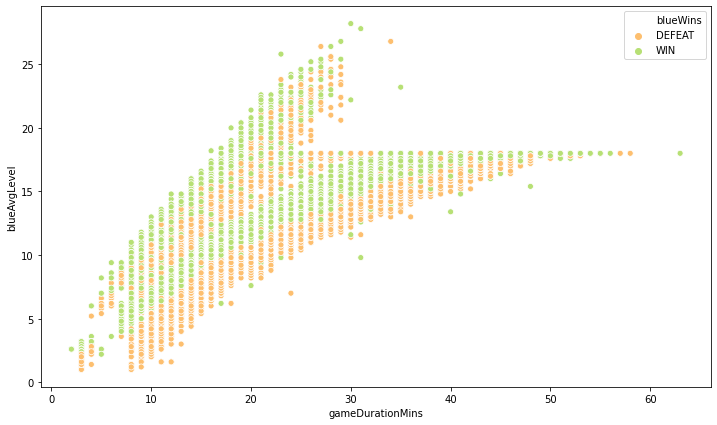

In [22]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=df['gameDurationMins'], y=df['blueAvgLevel'], hue=df['blueWins'], palette="RdYlGn")

In [23]:
df = df[df['blueAvgLevel'] <= 18]
df = df[df['redAvgLevel'] <= 18]
df.reset_index(inplace=True, drop=True)
df.head()

,gameId,ranking,gameDuration,gameDurationMins,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt,redWins,redFirstBlood,redFirstTower,redFirstBaron,redFirstDragon,redFirstInhibitor,redDragonKills,redBaronKills,redTowerKills,redInhibitorKills,redWardPlaced,redWardkills,redKills,redDeath,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4247263043,challenger,1323,22.0,DEFEAT,1,0,0,0,0,0,0,0,0,38,13,15,31,22,56039,37001,440,56,11.2,105,4,31035,5675,WIN,0,1,0,1,1,3,0,9,1,50,17,31,15,68,73016,49832,533,64,12.8,138,8,38711,60463
1,4247155821,challenger,1317,22.0,WIN,0,0,0,1,0,2,0,4,0,57,18,19,8,31,60243,41072,531,63,12.6,111,3,26397,45303,DEFEAT,1,1,0,0,0,0,0,2,0,46,18,8,19,8,44218,37136,571,59,11.8,134,3,24829,14105
2,4243963257,challenger,932,16.0,DEFEAT,0,0,0,0,0,0,0,0,0,28,7,5,20,8,24014,22929,306,42,8.4,64,0,6567,5651,WIN,1,1,0,1,1,2,0,5,1,40,9,20,5,20,30797,35364,400,50,10.0,89,5,12589,45201
3,4241678498,challenger,2098,35.0,DEFEAT,0,0,1,1,0,1,1,2,0,129,39,26,36,45,101607,63447,774,80,16.0,226,3,24718,31019,WIN,1,1,0,0,0,3,1,6,0,96,56,36,26,72,125866,70528,832,84,16.8,205,9,65312,88202
4,4241538868,challenger,2344,39.0,WIN,1,1,1,1,1,2,2,11,3,114,35,27,40,47,134826,74955,831,83,16.6,252,5,37161,95287,DEFEAT,0,0,0,0,0,3,1,6,1,100,43,40,27,83,131536,74596,794,85,17.0,227,7,86431,64141


## Conquista de vantagem em expepriência e nível é um fator impactante para vitória?

No league of legends ao entrar na partida seu personagem começa no nível 1 e pode chegar até o nível 18 ganhando experiência pelo mapa. 

O nível é um fator importante para a vitória uma vez que ele libera pontos de skills, liberando para o seu personagem novas habilidades e fazendo as habilidades já existentes ficarem mais fortes.

Como podemos podemos ver os times que coletaram mais experiência com o passar do tempo conquistaram mais vitórias.

Neste gráfico não estamos comparando o nível médio dos dois lados em uma mesma partida mas comparando com outras partidas do mesmo lado.

### Analisando o fator nível com as vitórias e derrotas do lado azul com o passar do tempo  

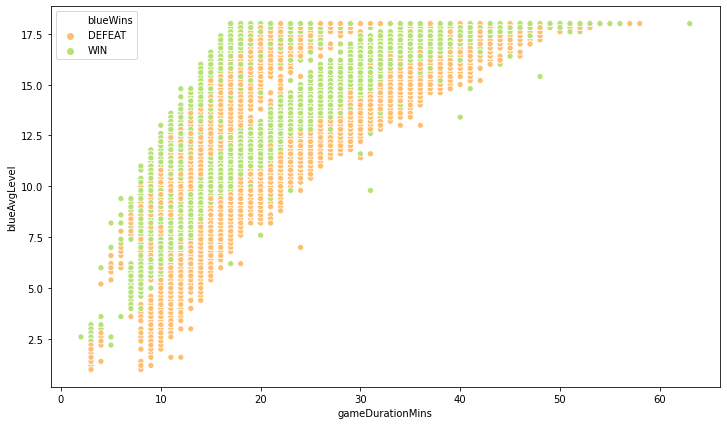

In [24]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=df['gameDurationMins'], y=df['blueAvgLevel'], hue=df['blueWins'], palette="RdYlGn")

In [25]:
df['redWins']

0            WIN
1         DEFEAT
2            WIN
3            WIN
4         DEFEAT
           ...  
198758    DEFEAT
198759       WIN
198760       WIN
198761       WIN
198762    DEFEAT
Name: redWins, Length: 198763, dtype: object

### Analisando o fator nível com as vitórias e derrotas do lado vermelho com o passar do tempo

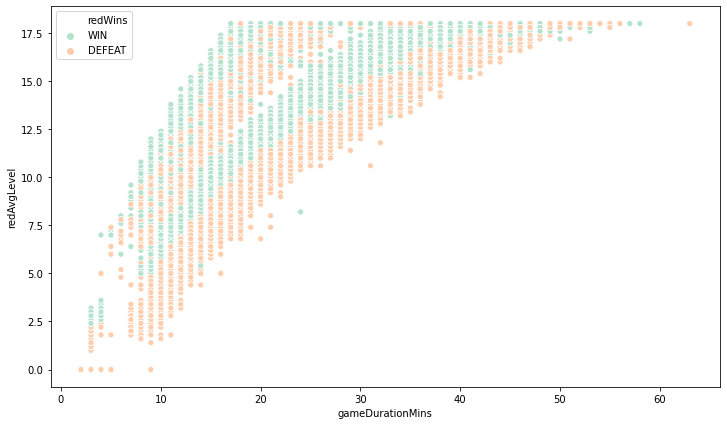

In [26]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=df['gameDurationMins'], y=df['redAvgLevel'], hue=df['redWins'], palette="Pastel2")

In [27]:
blue_f_baron = df.groupby('blueFirstBaron')['blueWins'].value_counts()
blue_f_baron

blueFirstBaron  blueWins
0               DEFEAT      92081
                WIN         59884
1               WIN         38693
                DEFEAT       8105
Name: blueWins, dtype: int64

## Baron, um objetivo game changing

O baron é um objetivo no mapa que quando abatido por um time concede a todos os seus membros 300 de ouro, buffs por 3 minutos nos status de todos os personagens do time e fortalece todas as tropas próximas aos personagens do time ao longo do mapa.
Queríamos verificar a taxa de efetividade que esse objetivo tinha nas vitórias, uma vez conquistado, pois esse objetivo é conhecido na comunidade como um objetivo que pode virar partidas ou garantir aquelas partidas que estão equilibradas, tendo em vista a força dos buffs que este objetivo entrega.

### Análise no lado azul

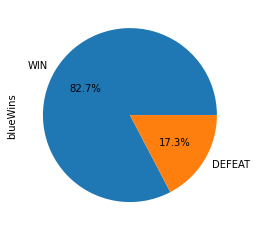

In [28]:
# Teams that claimed baron defeat and have actually won the match
blue_f_baron[1].plot.pie(autopct='%1.1f%%')

In [29]:
red_f_baron = df.groupby('redFirstBaron')['redWins'].value_counts()
red_f_baron

redFirstBaron  redWins
0              DEFEAT     90187
               WIN        57071
1              WIN        43115
               DEFEAT      8390
Name: redWins, dtype: int64

### Análise no lado vermelho

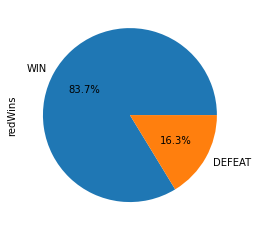

In [30]:
# Teams that claimed baron defeat and have actually won the match
red_f_baron[1].plot.pie(autopct='%1.1f%%')

In [31]:
columns = ['redWins', 'blueWins']

inv_win_mapping = {v: k for k, v in win_mapping.items()}

for col in columns:
    df[col] = df[col].map(inv_win_mapping)

In [32]:
blue_first_columns = ['blueWins', 'blueFirstBlood', 'blueFirstTower', 'blueFirstDragon', 'blueFirstBaron', 'blueFirstInhibitor']

blue_amount_columns = [
    'blueWins', 'blueKills', 'blueDeath', 'blueAssist', 'blueTowerKills', 'blueInhibitorKills', 'blueDragonKills', 'blueBaronKills',  'blueWardPlaced', 
    'blueWardkills', 'blueChampionDamageDealt', 'blueObjectDamageDealt', 'blueTotalGold', 'blueTotalMinionKills',  'blueTotalLevel', 'blueJungleMinionKills', 
    'blueKillingSpree', 'blueTotalHeal', 
] 

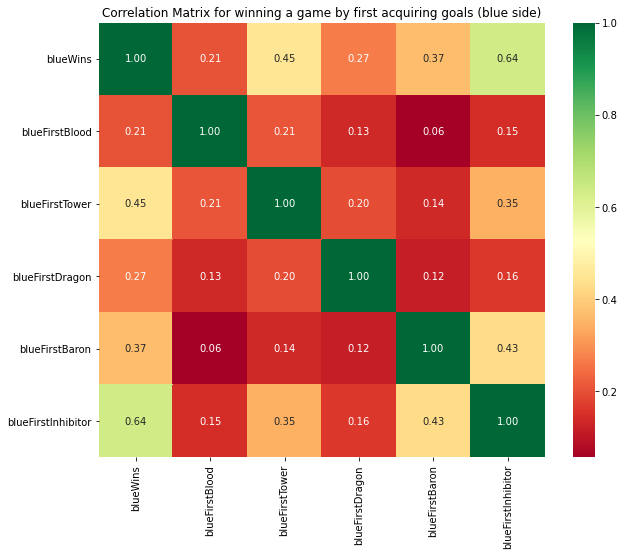

In [33]:
plt.figure(figsize=(10, 8))
plt.title("Correlation Matrix for winning a game by first acquiring goals (blue side)")
data = df[df['ranking'] == 'challenger'][blue_first_columns]
sns.heatmap(data.corr(method='pearson'), annot=True, fmt=".2f", cmap="RdYlGn")

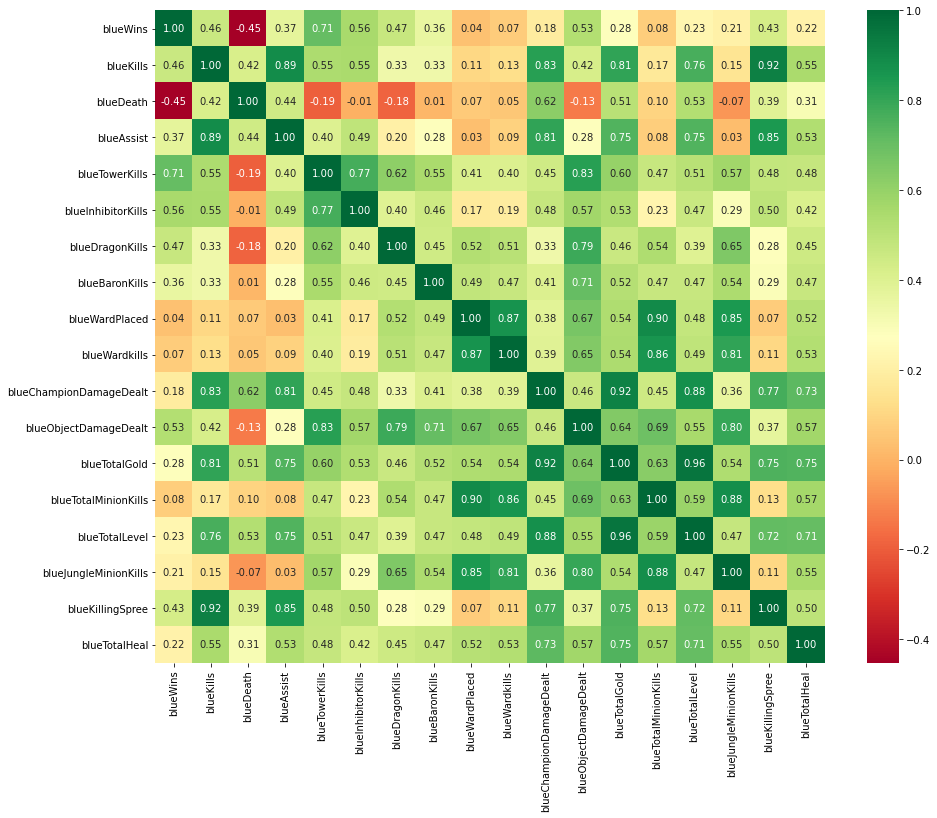

In [34]:
plt.figure(figsize=(15, 12))
data = df[df['ranking'] == 'challenger'][blue_amount_columns]
sns.heatmap(data.corr(method='pearson'), annot=True, fmt=".2f", cmap="RdYlGn")

In [35]:
red_first_columns = ['redWins', 'redFirstBlood', 'redFirstTower', 'redFirstDragon', 'redFirstBaron', 'redFirstInhibitor']

red_amount_columns = [
    'redWins', 'redKills', 'redDeath', 'redAssist', 'redTowerKills', 'redInhibitorKills', 'redDragonKills', 'redBaronKills',  'redWardPlaced', 
    'redWardkills', 'redChampionDamageDealt', 'redObjectDamageDealt', 'redTotalGold', 'redTotalMinionKills',  'redTotalLevel', 'redJungleMinionKills', 
    'redKillingSpree', 'redTotalHeal', 
]

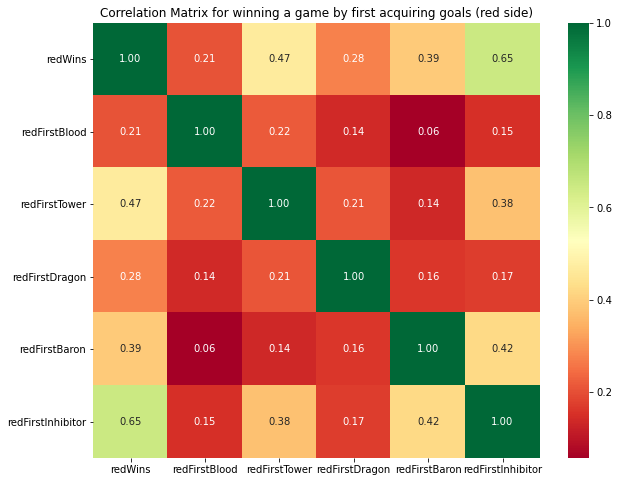

In [36]:
plt.figure(figsize=(10, 8))
plt.title("Correlation Matrix for winning a game by first acquiring goals (red side)")
data = df[red_first_columns]
sns.heatmap(data.corr(method='pearson'), annot=True, fmt=".2f", cmap="RdYlGn")

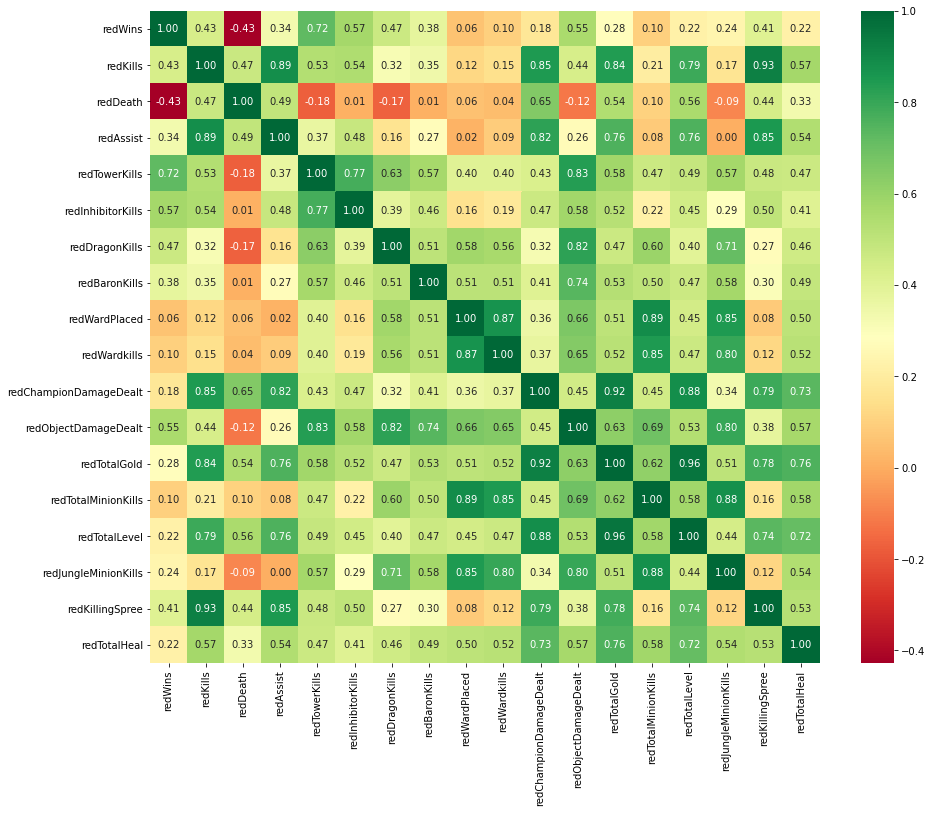

In [37]:
plt.figure(figsize=(15, 12))
data = df[red_amount_columns]
sns.heatmap(data.corr(method='pearson'), annot=True, fmt=".2f", cmap="RdYlGn")